This example shows how to use the function create_animation (found in modules/plotter.py) to create a mp4 or gif file animation of a time-lapse for 3D data. 

In [1]:
import xarray as xr
import numpy as np
from IPython.display import Video
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cmocean
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
import matplotlib.animation as animation

import sys
sys.path.append('../modules')
import nclcmaps as nclc

In [2]:
plt.rcParams['animation.ffmpeg_path'] = '/home/dnash/miniconda3/envs/pyclivac/bin/ffmpeg'

In [3]:
import matplotlib.animation as manimation
# import ffmpeg
manimation.writers.list()
# manimation.writers['ffmpeg']

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

In [4]:
## Choose case study
## get filenames for IVT and Precip
# year = 2020
# datelst = ['1128', '1129', '1130', '1201', '1202', '1203'] # december 2020 Haines event

year = 2018
datelst = ['0111', '0112', '0113', '0114', '0115', '0116'] # january 2018 Skagway event

# Choose extent (AK or SEAK)
ext1 = [-141., -130., 54., 61.] # extent of SEAK
ndeg=2. # how frequent grid lines are

# ext1 = [-175., -120., 40., 75.] # extend of AK
# ndeg=5. # how frequent grid lines are


figname = 'SEAK_jan2018'

### Load data

In [5]:
ivt_filenames = []
prec_filenames = []

for i, monthday in enumerate(datelst):
    ivt_filenames.append('/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}.nc'.format('IVT', monthday, str(year)))
    prec_filenames.append('/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}.nc'.format('Precip', monthday, str(year)))

In [6]:
###########################
### IVT and PRECIP DATA ###
###########################
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

# Open dataset using xarray
ivt = xr.open_mfdataset(ivt_filenames, preprocess=preprocess, combine='by_coords')
prec = xr.open_mfdataset(prec_filenames, preprocess=preprocess, combine='by_coords')


################################
### GEOPOTENTIAL HEIGHT DATA ###
################################

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(ext1[2], ext1[3]), longitude=slice(ext1[0], ext1[1]), level=250.)

# Set filepath
datdir = '/work/dnash/SEAK_clim_data/downloads/'
filename = 'ERA5/era5_uvq_prs_{0}*.nc'.format(year)
filepath_pattern = datdir + filename

# Open dataset using xarray
ds2 = xr.open_mfdataset(filepath_pattern, combine='by_coords')

rename_dict_upper = {'z': 'H', 
                     'latitude': 'lat',
                     'longitude': 'lon'}

ds2 = ds2.drop(labels=['q', 'u', 'v', 't'])
ds2 = ds2.rename(rename_dict_upper) # rename variables to something easier to understand
ds2 = ds2.reindex(lat=list(reversed(ds2.lat))) # make it so lats are -90 to 90
ds2 = ds2.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]), level=250.)
ds2 = ds2.assign(H=lambda ds2: ds2.H/(9.80665*10)) # convert to geopotential height (dam)
ds2.H.attrs['long_name'] = '250 hPa Geopotential Heights'
ds2.H.attrs['units'] = 'Geopotential Heights (dam)'

# merge ALL ds together
ds = xr.merge([ivt, prec, ds2])
ds

# clean ds
ds = ds.assign(prec_cum=lambda ds: ds.TP.cumsum(dim='time')) # calculate precipitation accumulation

# set these for the animation function
ds.IVT.attrs['long_name'] = 'IVT'
ds.IVT.attrs['units'] = 'IVT (kg m$^{-1}$ s$^{-1}$)'

ds.prec_cum.attrs['long_name'] = 'Accumulated Precipitation'
ds.prec_cum.attrs['units'] = 'Precipitation (mm)'
ds = ds.drop(labels=['uIVT', 'vIVT', 'IWV', 'TP'])
ds

<xarray.Dataset>
Dimensions:   (time: 144, lat: 29, lon: 45)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-11 ... 2018-01-16T23:00:00
  * lat       (lat) float64 54.0 54.25 54.5 54.75 55.0 ... 60.25 60.5 60.75 61.0
  * lon       (lon) float64 -141.0 -140.8 -140.5 -140.2 ... -130.5 -130.2 -130.0
    level     int32 250
Data variables:
    IVT       (time, lat, lon) float64 dask.array<chunksize=(24, 29, 45), meta=np.ndarray>
    H         (time, lat, lon) float32 dask.array<chunksize=(144, 29, 45), meta=np.ndarray>
    prec_cum  (time, lat, lon) float64 dask.array<chunksize=(24, 29, 45), meta=np.ndarray>
Attributes:
    Conventions:                CF-1/0
    history:                    Mon Jul 13 14:42:37 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Mon Jul 13 14:42:37 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [7]:
%%time
ds = ds.load()

CPU times: user 3.47 s, sys: 6.28 s, total: 9.75 s
Wall time: 6.56 s


In [8]:
ds.prec_cum.max()

<xarray.DataArray 'prec_cum' ()>
array(303.62877328)
Coordinates:
    level    int32 250

In [9]:
ds.IVT.max()

<xarray.DataArray 'IVT' ()>
array(1000.22381701)
Coordinates:
    level    int32 250

In [10]:
# choose variable from dataset
var1 = 'IVT'
var2 = 'H'
var3 = 'prec_cum'

# set levels for contour plot
clevs1 = np.arange(250, 1500, 125) # levels for IVT
clevs2 = np.arange(840, 1280, 12) # levels for geopotential heights
clevs3 = np.arange(50, 400, 50) # levels for precipitation

# set cmap for contour plot
cmap1 = cmo.deep
cmap2 = None
cmap3 = nclc.cmap('WhiteBlueGreenYellowRed')

# set up map parameters
datacrs=ccrs.PlateCarree()
mapcrs=ccrs.Mercator()

# set up grid labels

xticks = np.arange(ext1[0], ext1[1]+ndeg, ndeg)
yticks = np.arange(ext1[2], ext1[3]+ndeg, ndeg)

DS = ds

In [11]:
def draw_basemap(extent, datacrs, mapcrs, xticks, yticks):
    '''This function draws a basemap for the AK animation maps'''
    fig = plt.figure(figsize=(3, 3))
    
    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 1), axes_pad = 0.45,
                    cbar_location='right', cbar_mode='single',
                    cbar_pad=0.2, cbar_size='3%',label_mode='')
#     ax = fig.add_subplot(1, 1, 1, projection=mapcrs)

    for k, ax in enumerate(axgr):
    
        ax.set_extent(extent, crs=datacrs)

        # Add map features (continents and country borders)
        ax.add_feature(cfeature.LAND, facecolor='0.9')      
        ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
        ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

        # add in meridians and parallels
        gl = ax.gridlines(crs=datacrs, draw_labels=True,
                          linewidth=.5, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = True
        gl.right_labels = False
        gl.bottom_labels = True
        gl.xlocator = mticker.FixedLocator(xticks)
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'gray'}
        gl.ylabel_style = {'size': 10, 'color': 'gray'}
    
    
    return fig, ax, axgr



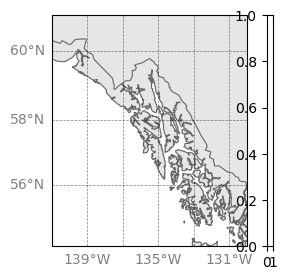

In [12]:
## test draw_basemap func
draw_basemap(ext1, datacrs, mapcrs, xticks, yticks);

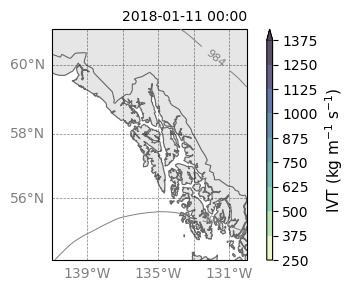

In [13]:
## test first timestep
_, ax, axgr = draw_basemap(ext1, datacrs, mapcrs, xticks, yticks)
# plot the variables
VO1 = DS[var1].values[0]
VO2 = DS[var2].values[0]
VO3 = DS[var3].values[0]

lons = DS.lon
lats = DS.lat

units = DS[var1].units
units2 = DS[var3].units
# Set title based on long name and current time step
ts = pd.to_datetime(str(DS.time.values[0])).strftime("%Y-%m-%d %H:%M")

# Add contour plot (line)
cs = ax.contour(lons, lats, VO2, transform=datacrs,
                levels=clevs2, colors='grey', 
                linewidths=0.7, linestyles='solid', zorder=10)
kw_clabels = {'fontsize': 8, 
              'inline': True, 
              'inline_spacing': 10, 
              'fmt': '%i',
              'rightside_up': True, 
              'use_clabeltext': True}
plt.clabel(cs, **kw_clabels)

# Add contour plot (shaded precip)
cf2 = ax.contourf(lons, lats, VO3, 
                  transform=datacrs, cmap=cmap3, 
                  levels=clevs3, zorder=5, 
                  extend='max', alpha=0.5)

# Add contour plot (shaded)
cf = ax.contourf(lons, lats, VO1, 
                 transform=datacrs, cmap=cmap1, 
                 levels=clevs1, zorder=0, 
                 extend='max', alpha=0.8)

# Colorbar (single)
cb = _.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label(units, fontsize=11)
cb.ax.tick_params(labelsize=10)

# add title
ax.set_title(ts, fontsize=10, loc='right')

plt.show()

In [14]:
def draw(frame, ax, axgr, add_colorbar=True):
    '''add the shaded and line contours, add the colormap'''
    # Clear current axis to overplot next time step
    ax.clear() # this works but removes the basemap!!
    ## hack - add this in here so it keeps basemap info
    ax.set_extent(ext1, crs=datacrs)

    # Add map features (continents and country borders)
    ax.add_feature(cfeature.LAND, facecolor='0.9')      
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

    # add in meridians and parallels
    gl = ax.gridlines(crs=datacrs, draw_labels=True,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.bottom_labels = True
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    
    ### Now let's plot our data!
    # values to plot
    VO1 = DS[var1].values[frame]
    VO2 = DS[var2].values[frame]
    VO3 = DS[var3].values[frame]
    # lats and lons
    lons = DS.lon
    lats = DS.lat
    # units for cmap
    units = DS[var1].units
    # Set title based on long name and current time step
    ts = pd.to_datetime(str(DS.time.values[frame])).strftime("%Y-%m-%d %H:%M")
    
    # Add contour plot (line)
    cs = ax.contour(lons, lats, VO2, transform=datacrs,
                    levels=clevs2, colors='grey', 
                    linewidths=0.7, linestyles='solid', zorder=10)
    kw_clabels = {'fontsize': 8, 
                  'inline': True, 
                  'inline_spacing': 10, 
                  'fmt': '%i',
                  'rightside_up': True, 
                  'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)

    # Add contour plot (shaded precip)
    cf2 = ax.contourf(lons, lats, VO3, 
                      transform=datacrs, cmap=cmap3, 
                      levels=clevs3, zorder=5, 
                      extend='max', alpha=0.5)

    # Add contour plot (shaded)
    cf = ax.contourf(lons, lats, VO1, 
                     transform=datacrs, cmap=cmap1, 
                     levels=clevs1, zorder=0, 
                     extend='max', alpha=0.8)
    
    # add title
    ax.set_title(ts, fontsize=10, loc='right')
    
    if add_colorbar == True:
        # Colorbar (single)
        cb = _.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
        cb.set_label(units, fontsize=11)
        cb.ax.tick_params(labelsize=10)
    
    
    return cf


def init():
    '''Draw initial frame'''
    return draw(0, ax, axgr, add_colorbar=True)


def animate(frame):
    '''Draw current frame'''
    return draw(frame, ax, axgr, add_colorbar=False)

In [15]:
## now create animation
fig, ax, axgr = draw_basemap(ext1, datacrs, mapcrs, xticks, yticks)

frames = DS.time.size        # Number of frames

ani = animation.FuncAnimation(fig, animate, frames, interval=0.01, blit=False,
                              init_func=init, repeat=False)
ani.save('../figs/{0}.gif'.format(figname), writer=animation.FFMpegWriter(fps=8))
plt.close(fig)